In [ ]:
# This makes a block diagram from information in the FITS headers

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy
from astropy.io import fits
import pandas as pd
from datetime import datetime
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib qt 
#%matplotlib inline

In [2]:
# constants

asec_per_rad = np.divide(180.*3600.,np.pi) # arcsec per radian
plate_scale = 0.0107 # asec/pix
d_altair = 5.13 # pc (from Hipparcos, via Leeuwen)
d_sirius = 2.6 # pc
d_procyon = 3.5 # pc
size_cutout = 100 # plus-minus this much around psf center to make cutouts

In [3]:
psf_pos = (864,117) # set the center of the PSF (x,y)
#psf_pos = (1137,117) # set the center of the PSF (x,y)

In [4]:
# read in LEECH contrast curves for Altair

del_mag_leech = pd.read_csv("leech_contrast/HIP97649_LEECH.txt")
rad_leech = pd.read_csv("leech_contrast/radii_LEECH.txt") # radii, in arcseconds
leech = pd.concat([rad_leech,del_mag_leech], axis=1) # combine into one dataframe

In [5]:
# stem 

stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/')

In [6]:
def calc_ctrl_radius(lambda_wavel, r_subap, pix=True):
    '''
    Find the control radius of the observation
    
    INPUTS--
    lambda_wavel: wavelength of the observation (m)
    r_subap: intersubaperture spacing (m)
    pix: in pixel space (False = in asec)
    
    OUTPUT--
    ctrl_rad: the control radius in pixels (by default) or arcseconds
    '''
    
    ctrl_rad_rad = np.divide(lambda_wavel,2*r_subap) # approx. control radius in radians
    
    if (pix==True):
        ctrl_rad = np.divide(np.multiply(ctrl_rad_rad,asec_per_rad),plate_scale)
    else:
        ctrl_rad = np.multiply(ctrl_rad_rad,asec_per_rad)
        
    return ctrl_rad

In [7]:
def calc_au_radius(d_star, n_au, pix=True):
    '''
    Find the radius on the detector equivalent to a given AU around a star
    
    INPUTS--
    d_star: distance of the star from Earth (pc)
    n_au: orbital distance in AU around that star (AU)
    pix: in pixel space (False = in asec)
    
    OUTPUT--
    au_rad: the equivalent radius in pixels (by default) or arcseconds
    '''
    
    r_asec = np.divide(n_au,d_star) # the radial distance in asec
    
    if (pix==True):
        r = np.divide(r_asec,plate_scale) # radius in pix
    else:
        r = r_asec
    
    return r

In [8]:
def asec_to_pix(asec):
    '''
    Handy asec to pixels conversion
    '''
    return np.divide(asec,plate_scale)

In [9]:
gauss_kernel = Gaussian1DKernel(5)

def remove_ramp_return_ramps_image(sciImg):
    '''
    Remove the stray y-illumination from the detector reset, but not the photon-signal pedestal
    it appears to be sitting on. This is especially relevant for UP nods of the Altair dataset.
    '''
    
    # find the median in x across the whole array as a function of y
    stray_ramp = np.nanmedian(sciImg[:,:],axis=1)
    #plt.plot(stray_ramp)
    #plt.show()

    # smooth it
    smoothed_stray_ramp_inc_photons = convolve(stray_ramp, gauss_kernel) # this is 1D
    
    # subtract the (apparent) photon pedestal from the ramp model
    # (this subtracts--from the ramp to be subtracted--the lower-y component which is least affected by the ramp effect)
    smoothed_stray_ramp_wo_photons = np.subtract(smoothed_stray_ramp_inc_photons,
                                                 np.nanmedian(smoothed_stray_ramp_inc_photons[5:100]))

    #print(np.nanmedian(smoothed_stray_ramp_inc_photons[5:100]))
    
    # subtract from the whole array (note there will still be residual channel pedestals)
    sciImg1 = np.subtract(sciImg,np.tile(smoothed_stray_ramp_wo_photons,(2048,1)).T)

    return [smoothed_stray_ramp_inc_photons,smoothed_stray_ramp_wo_photons,sciImg1]

In [10]:
def simple_mask(sciImg, mask_psf=False):
    '''
    Get rid of regions near PSF or other weird places
    '''
    
    mask_weird = np.ones(np.shape(sciImg))
    mask_weird[0:4,:] = np.nan # lower edge
    mask_weird[-4:,:] = np.nan # upper edge
    mask_weird[:,0:4] = np.nan # left edge
    mask_weird[260:,1046:1258] = np.nan # bullet hole
    mask_weird[:,1500:] = np.nan # unreliable bad pixel mask
    mask_weird[:,:440] = np.nan # unreliable bad pixel mask
    
    if mask_psf:
        mask_weird[:,700:1025] = np.nan # get rid of large area around PSF too
    
    return np.multiply(sciImg,mask_weird)

In [11]:
# figure out some of the relevant radii

ctrl_rad = calc_ctrl_radius(lambda_wavel=4.06e-6,r_subap=8.25/30) # control radius
one_au_altair = calc_au_radius(d_star=d_altair, n_au=1., pix=True) # 1 AU
two_au_altair = calc_au_radius(d_star=d_altair, n_au=2., pix=True) # 2 AU

one_au_sirius = calc_au_radius(d_star=d_sirius, n_au=1., pix=True) # 1 AU
one_au_procyon = calc_au_radius(d_star=d_procyon, n_au=1., pix=True) # 1 AU

bkgrnd_limit_leech_altair = asec_to_pix(2.4) # general contrast-limited radius, given LEECH contrast curve of Altair

# Find read noise levels

/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", 

----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan

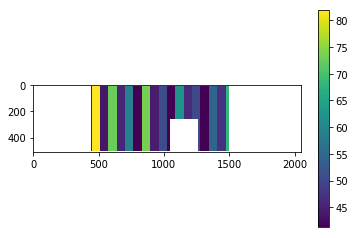

In [17]:
# find read noise between 2 readouts

framenum = 8327
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'.fits'
img_string2 = 'lm_180507_'+str("{:0>6d}".format(framenum+1))+'.fits' # second frame to find read noise
    
# if file exists
if os.path.isfile(stem+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem+img_string,0,header=True)
    sciImg2, header2 = fits.getdata(stem+img_string2,0,header=True) # second frame to find read noise
    
    # initialize 2D S/N arrays
    #sn_array_photon_only = np.zeros(np.shape(sciImg),dtype=float)
    #sn_array_photon_and_RN = np.zeros(np.shape(sciImg),dtype=float)
    
    # initialize 2D read noise array
    RN_array = np.ones(np.shape(sciImg),dtype=float)
    
    # remove ramp effect, then mask
    test = simple_mask(remove_ramp_return_ramps_image(sciImg)[2], mask_psf=False)
    test2 = simple_mask(remove_ramp_return_ramps_image(sciImg2)[2], mask_psf=False) # second frame to find read noise
            
    # loop over channels
    for chNum in range(0,32):
        
        # flux in this channel
        channel_flux_2d = test[:,chNum*64:(chNum+1)*64] 
            
        # difference the two readouts
        diff_img = np.subtract(channel_flux_2d,test2[:,chNum*64:(chNum+1)*64])
        # divide std of difference by sqrt(2), and try to avoid region near PSF
        sig_read = np.divide(np.nanstd(diff_img[5:35,:]),np.sqrt(2.)) 
        
        sig_tot = np.nanstd(channel_flux_2d[5:35,:]) # find total noise
        sig_phot_calc = np.sqrt(np.power(sig_tot,2.)-np.power(sig_read,2.)) # the photon noise we'd expect
        
        
        # FYI stuff
        print('----')
        print('read noise:')
        print(sig_read)
        print('total noise in channel:')
        print(sig_tot)
        print('calc photon noise in channel (given total scatter and measured read noise):')
        print(sig_phot_calc)
        print('expected photon noise in channel (given median photon counts):')
        print(np.sqrt(np.nanmedian(channel_flux_2d)))
         
           
        # now, within the channel, using the calculated value of RN, find S/N
        # via S/N = Isky/sqrt(Isky + sigRN^2)
            
        # S/N in this channel (assuming only terms are photon and read noise)
        #s_to_n_channel_photon_only = np.sqrt(channel_flux_2d) # photon noise only
        #s_to_n_channel_photon_and_RN = np.divide(channel_flux_2d,
        #                                  np.sqrt(channel_flux_2d + np.power(sig_read,2.)))
        
        # put channel info into larger array
        #sn_array_photon_only[:,chNum*64:(chNum+1)*64] = s_to_n_channel_photon_only
        #sn_array_photon_and_RN[:,chNum*64:(chNum+1)*64] = s_to_n_channel_photon_and_RN
        RN_array[:,chNum*64:(chNum+1)*64] *= sig_read
        
    else:
        
        print('File '+img_string+' not found')
        
RN_array = simple_mask(RN_array, mask_psf=False) # overlay same mask

'''
plt.imshow(RN_array)
plt.colorbar()
plt.show()
'''

In [27]:
np.nanstd(test)

1072.2977471882145

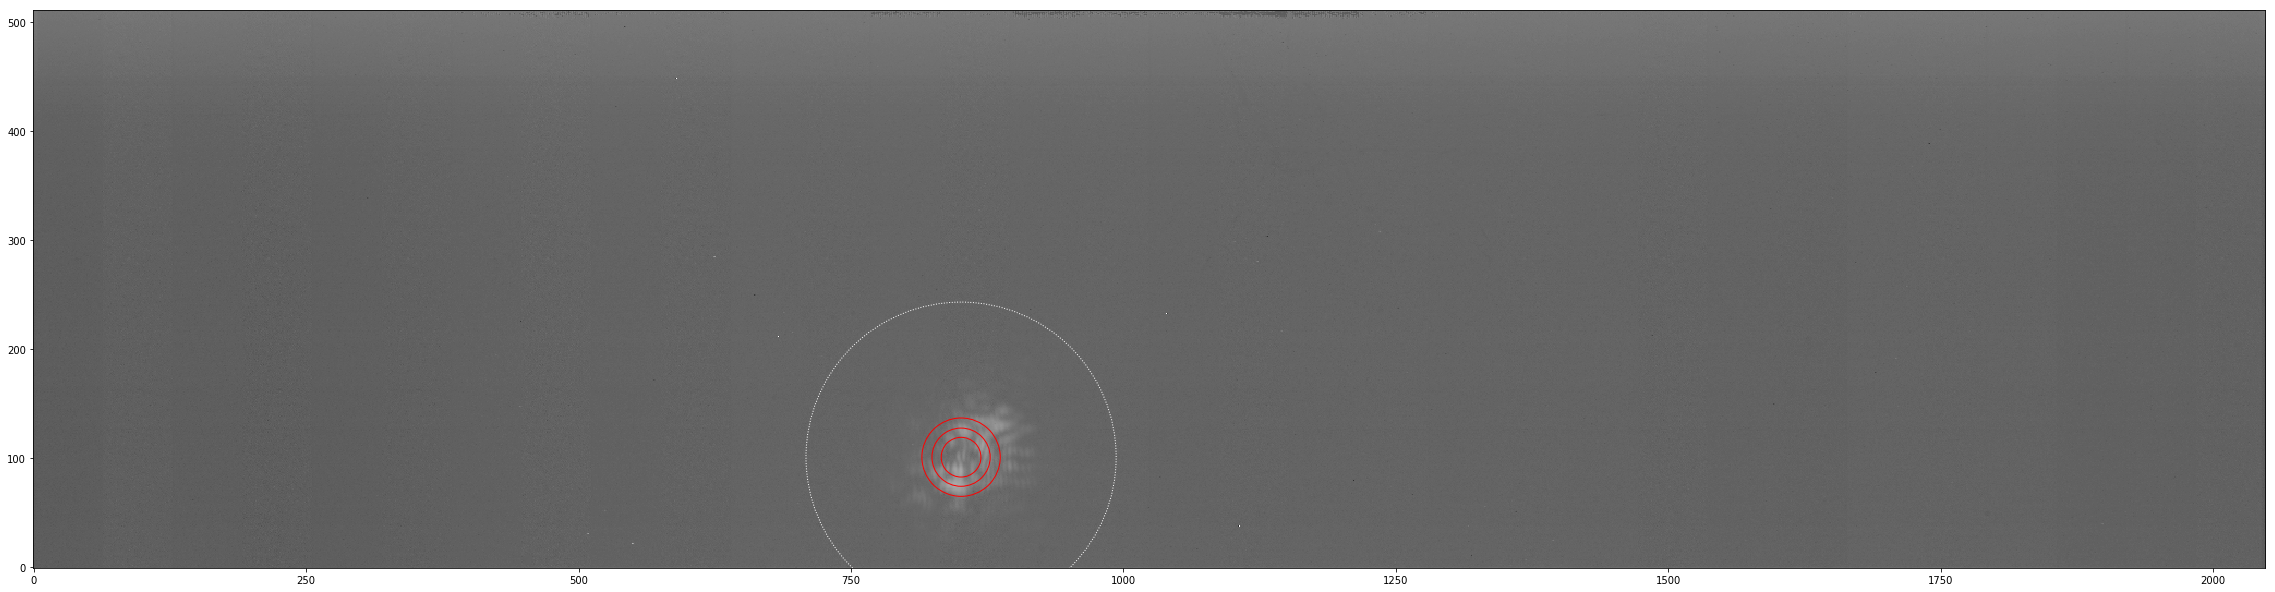

Saved 011375


In [48]:
# handy code for putting circles on stuff

from matplotlib.colors import LogNorm

stemExample = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/')

framenum = 11375
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'.fits'

test, header = fits.getdata(stemExample+img_string,0,header=True)

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111)

plot = ax.imshow(np.add(test,1000), norm=LogNorm(vmin=100, vmax=61500), origin="lower", cmap="gray") # offset to make log display right
#plot = ax.imshow(test, origin="lower", cmap="gray") # offset to make log display right

# FYI: draw circles over PSF
psf_pos = (851,101) # set the center of the PSF (x,y)
ctrl_radius_pix = ctrl_rad
circ_ctrl_rad = Circle(psf_pos,ctrl_radius_pix,label='Control Radius',linestyle=':',color="white",fill=False) # control radius
ax.add_patch(circ_ctrl_rad)
    

one_au_radius_pix = one_au_altair
circ_one_au = Circle(psf_pos,one_au_radius_pix,label='1 AU',color="red",fill=False) # control radius
ax.add_patch(circ_one_au)

one_au_radius_pix = one_au_sirius
circ_one_au = Circle(psf_pos,one_au_radius_pix,label='1 AU',color="red",fill=False) # control radius
ax.add_patch(circ_one_au)

one_au_radius_pix = one_au_procyon
circ_one_au = Circle(psf_pos,one_au_radius_pix,label='1 AU',color="red",fill=False) # control radius
ax.add_patch(circ_one_au)

#two_au_radius_pix = two_au_altair
#circ_two_au = Circle(psf_pos,two_au_radius_pix,label='2 AU',fill=False) # control radius
#ax.add_patch(circ_two_au)
    
#circ_leech_bkgrnd = Circle(psf_pos,bkgrnd_limit_leech_altair,label='LEECH bkgrnd limit (2.4 asec)',linestyle='--',fill=False) # control radius
#ax.add_patch(circ_leech_bkgrnd)    

#ax.legend() #loc='center left', bbox_to_anchor=(1., 0.5))

plt.savefig('test.png', dpi=300, overwrite=True)
plt.show()
           
# write back out
#hdu = fits.PrimaryHDU(sciImg1.astype(np.float32), header=header)
#hdul = fits.HDUList([hdu])
#hdul.writeto(stem+'../../02_stray_ramp_removed/'+img_string, overwrite=True)
print('Saved '+str("{:0>6d}".format(framenum)))

#plt.imshow(sn_array, origin="lower")
#plt.colorbar()
#plt.show()
 

In [26]:
## ## OLD CODE

# read in a frame and 
# 1. print some noise values
# 2. overplot some relevant circles

for framenum in range(8327,8328):
    img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'.fits'
    img_string2 = 'lm_180507_'+str("{:0>6d}".format(framenum+1))+'.fits' # second frame to find read noise
    
    print(stem+img_string)
    
    # if file exists
    if os.path.isfile(stem+img_string):
        
        # read in image
        sciImg, header = fits.getdata(stem+img_string,0,header=True)
        sciImg2, header2 = fits.getdata(stem+img_string2,0,header=True) # second frame to find read noise
    
        # initialize 2D S/N arrays
        sn_array_photon_only = np.zeros(np.shape(sciImg),dtype=float)
        sn_array_photon_and_RN = np.zeros(np.shape(sciImg),dtype=float)
        RN_array = np.ones(np.shape(sciImg),dtype=float)
    
        # remove ramp effect, then mask
        test = simple_mask(remove_ramp_return_ramps_image(sciImg)[2], mask_psf=False)
        test2 = simple_mask(remove_ramp_return_ramps_image(sciImg2)[2], mask_psf=False) # second frame to find read noise
            
        # loop over channels
        for chNum in range(0,32):
            print('----')
        
            # flux in this channel
            channel_flux_2d = test[:,chNum*64:(chNum+1)*64] 
            
            # difference the two readouts
            diff_img = np.subtract(channel_flux_2d,test2[:,chNum*64:(chNum+1)*64])
            print('read noise:')
            sig_read = np.divide(np.nanstd(diff_img),np.sqrt(2.)) # divide std of difference by sqrt(2)
            print(sig_read)
        
            sig_tot = np.nanstd(channel_flux_2d) # find total noise
            sig_phot_calc = np.sqrt(np.power(sig_tot,2.)-np.power(sig_read,2.)) # the photon noise we'd expect
            print('total noise in channel:')
            print(sig_tot)
            print('calc photon noise in channel (given total scatter and measured read noise):')
            print(sig_phot_calc)
            print('expected photon noise in channel (given median photon counts):')
            print(np.sqrt(np.nanmedian(channel_flux_2d)))
            
            # now, within the channel, using the calculated value of RN, find S/N
            # via S/N = Isky/sqrt(Isky + sigRN^2)
            
            # S/N in this channel (assuming only terms are photon and read noise)
            s_to_n_channel_photon_only = np.sqrt(channel_flux_2d) # photon noise only
            s_to_n_channel_photon_and_RN = np.divide(channel_flux_2d,
                                          np.sqrt(channel_flux_2d + np.power(sig_read,2.)))
        
            # put channel info into larger array
            sn_array_photon_only[:,chNum*64:(chNum+1)*64] = s_to_n_channel_photon_only
            sn_array_photon_and_RN[:,chNum*64:(chNum+1)*64] = s_to_n_channel_photon_and_RN
            RN_array[:,chNum*64:(chNum+1)*64] *= sig_read
            

        '''
        fig = plt.figure(figsize=(40,20))
        ax = fig.add_subplot(111)

        plot = ax.imshow(test, origin="lower")
    
        # FYI: draw circles over PSF
        psf_pos = (864,117) # set the center of the PSF (x,y)
        ctrl_radius_pix = ctrl_rad
        circ_ctrl_rad = Circle(psf_pos,ctrl_radius_pix,label='Control Radius',linestyle=':',fill=False) # control radius
        ax.add_patch(circ_ctrl_rad)
    
        one_au_radius_pix = one_au
        circ_one_au = Circle(psf_pos,one_au_radius_pix,label='1 AU',fill=False) # control radius
        ax.add_patch(circ_one_au)
    
        two_au_radius_pix = two_au
        circ_two_au = Circle(psf_pos,two_au_radius_pix,label='2 AU',fill=False) # control radius
        ax.add_patch(circ_two_au)
    
        circ_leech_bkgrnd = Circle(psf_pos,bkgrnd_limit_leech_altair,label='LEECH bkgrnd limit (2.4 asec)',linestyle='--',fill=False) # control radius
        ax.add_patch(circ_leech_bkgrnd)    
    
        ax.legend() #loc='center left', bbox_to_anchor=(1., 0.5))
    
        #plt.savefig('altair_radii_plot.png', dpi=300, overwrite=False)
        #plt.show()
           
        # write back out
        #hdu = fits.PrimaryHDU(sciImg1.astype(np.float32), header=header)
        #hdul = fits.HDUList([hdu])
        #hdul.writeto(stem+'../../02_stray_ramp_removed/'+img_string, overwrite=True)
        print('Saved '+str("{:0>6d}".format(framenum)))

        plt.imshow(sn_array, origin="lower")
        plt.colorbar()
        plt.show()
        '''
        
    else:
        
        print('File '+img_string+' not found')

/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008327.fits
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given tot

/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/unasemaje/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", 

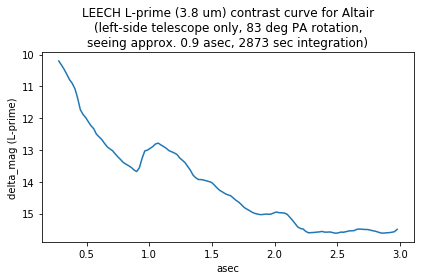

In [66]:
# make a plot of the LEECH data

plt.plot(leech['radius'],leech['del_mag'])
plt.title('LEECH L-prime (3.8 um) contrast curve for Altair\n(left-side telescope only, 83 deg PA rotation,\nseeing approx. 0.9 asec, 2873 sec integration)')
plt.ylabel('delta_mag (L-prime)')
plt.xlabel('asec')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('leech_altair_contrast.pdf', overwrite=False)
#plt.show()

# Make a cube of phase-controlled data (if one hasn't been saved already)

In [12]:
# read in FITS header meta data

full_table = pd.read_csv('fizeau_altair_180507_metadata.csv')

/home/unasemaje/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,80,81,84,88,92,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# sort table by frame number (a few are out of order)

full_table.sort_values(["FRAMENUM"], inplace=True)
full_table = full_table.reset_index(drop=True) # reset indices and don't keep the old ones

In [14]:
# read in a dark-subtracted FITS file, and
# 1. remove stray voltage effect (to leave only photon-related signal) 
# 2. take a cut-out (to save some memory), 
# 3. put it into a cube 

# frames 8327 to 8599 are a pretty stable phase-controlled sequence, 
# with the exception of a few phase jumps 

startFrame = 8327
stopFrame = 8599 # (non-inclusive)

array_cube = np.zeros((stopFrame-startFrame,2*size_cutout,2*size_cutout), dtype = np.float64) # initialize cube

for framenum in range(startFrame,stopFrame):
    img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'.fits'
    #img_string2 = 'lm_180507_'+str("{:0>6d}".format(framenum+1))+'.fits' # for calculating read noise
    
    print(stem+img_string)
    
    # if file exists
    if os.path.isfile(stem+img_string):
        
        # read in image
        sciImg, header = fits.getdata(stem+img_string,0,header=True)
        #sciImg2, header = fits.getdata(stem+img_string2,0,header=True)
    
        # remove ramp effect, then mask
        test = simple_mask(remove_ramp_return_ramps_image(sciImg)[2], mask_psf=False)
        #test2 = simple_mask(remove_ramp_return_ramps_image(sciImg2)[2], mask_psf=False)
    
        #fig = plt.figure()
        #ax = fig.add_subplot(111)

        #plot = ax.imshow(test, origin="lower")

        cutout = test[psf_pos[1]-size_cutout:psf_pos[1]+size_cutout,
                      psf_pos[0]-size_cutout:psf_pos[0]+size_cutout] # make a cutout with a bounding box
        
        array_cube[framenum-startFrame,:,:] = cutout
        
    else:
        
        print('File '+img_string+' not found')

/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008327.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008328.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008329.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008330.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008331.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008332.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008333.fits
/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attemp

In [15]:
# save the cube for safety

hdu = fits.PrimaryHDU(array_cube.astype(np.float64))
hdul = fits.HDUList([hdu])
hdul.writeto(stem+'../../experimentation/cube_test_'+str("{:0>6d}".format(size_cutout))+'.fits', overwrite=False)

Saved 008598


# Do S/N analysis of the array

In [16]:
# read in cube of images

array_cube = fits.getdata(stem+'../../experimentation/cube_test_'+str("{:0>6d}".format(size_cutout))+'.fits',0,header=False)

In [17]:
# read in a raw frame to get a rough idea of where the nonlinear regime is 
# (> 50000 in 2018A data is at least ~3% nonlinear)

rawFrame, rawHeader = fits.getdata(stem+'../../raw_data/'+'lm_180507_'+str("{:0>6d}".format(8400))+'.fits',0,header=True)
rawFrame_1d = np.ravel(rawFrame)
rawFrame_1d[np.where(rawFrame_1d < 50000)] = 0 # pretty linear
rawFrame_1d[np.where(rawFrame_1d > 50000)] = 1 # significantly nonlinear
rawFrame = np.reshape(rawFrame_1d, np.shape(rawFrame))

rawFrame_cutout = rawFrame[psf_pos[1]-size_cutout:psf_pos[1]+size_cutout,
                      psf_pos[0]-size_cutout:psf_pos[0]+size_cutout]

In [19]:
# find stdev for each pixel, across time

array_std_time = np.nanstd(array_cube, axis=0)
array_median_time = np.nanmedian(array_cube, axis=0)

In [20]:
# empirical S/N (as calculated across time)

empirical_s_to_n = np.divide(array_median_time,array_std_time)

In [21]:
# S/N assuming photon noise only

background_only_s_to_n = np.sqrt(array_median_time)

In [22]:
# S/N assuming photon and read noise only

set_sig_RN = 50 # set sigma read noise level
background_and_RN_s_to_n = np.divide(array_median_time,np.sqrt(array_median_time + np.power(set_sig_RN,2.)))

In [39]:
# ratio of S/N: empirical to background-limited

ratio_SN_empir_compared_to_bkgd_only = np.divide(empirical_s_to_n,background_only_s_to_n)

In [59]:
# ratio of S/N: empirical to background-and-RN-limited

ratio_SN_empir_compared_to_bkgdAndRN_only = np.divide(empirical_s_to_n,background_and_RN_s_to_n)

In [60]:
# make S/N-relevant plots

plt.clf()
fig, axes = plt.subplots(2, 3)

im1 = axes[0,0].imshow(empirical_s_to_n, vmin=0, vmax=20, origin="lower")
axes[0,0].set_title('Empirical S/N:\nS/N=flux/stdev_in_time')
fig.colorbar(im1, ax = axes[0,0])
im2 = axes[0,1].imshow(background_only_s_to_n, vmin=0, vmax=250, origin="lower")
axes[0,1].set_title('Background-only assumption:\nS/N=Sqrt(flux)')
fig.colorbar(im2, ax = axes[0,1])
im3 = axes[0,2].imshow(ratio_SN_empir_compared_to_bkgd_only, vmin=0, vmax=2.5, origin="lower")
fig.colorbar(im3, ax = axes[0,2])
axes[0,2].set_title('Ratio of S/N: empirical\nover bkgd-only assumption\n(1: background-limited; <1: contrast\nlimit, or other large noise terms present)')

im4 = axes[1,0].imshow(rawFrame_cutout, origin="lower", cmap="gray")
axes[1,0].set_title('Nonlinearity:\nwhite = at least 3 percent nonlinear')
fig.colorbar(im4, ax = axes[1,0])
im5 = axes[1,1].imshow(background_and_RN_s_to_n, vmin=0, vmax=250, origin="lower")
axes[1,1].set_title('Background and RN assumption:\nS/N=flux/Sqrt(flux+sig_RN^2)')
fig.colorbar(im5, ax = axes[1,1])
im6 = axes[1,2].imshow(ratio_SN_empir_compared_to_bkgdAndRN_only, vmin=0, vmax=2.5, origin="lower")
fig.colorbar(im6, ax = axes[1,2])
axes[1,2].set_title('Ratio of S/N: empirical\nover bkgd+RN only assumption')

#plt.tight_layout()
#plt.savefig("test.png", dpi=300)

plt.show()

In [83]:
# make plot of where photon and RN regime breaks down

plt.clf()
test_1d = np.ravel(np.copy(ratio_SN_empir_compared_to_bkgdAndRN_only))
cutoff = 0.9
test_1d[np.where(test_1d < cutoff)] = -9999
test_1d[np.where(test_1d > cutoff)] = np.nan 
breakdown = np.reshape(test_1d, np.shape(ratio_SN_empir_compared_to_bkgdAndRN_only))

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.imshow(breakdown, origin="lower", cmap="gray")

# FYI: draw circles over PSF
one_au_radius_pix = one_au
circ_one_au = Circle((100,100),one_au_radius_pix,label='1 AU',edgecolor="red",fill=False) # control radius
ax.add_patch(circ_one_au)
    
two_au_radius_pix = two_au
circ_two_au = Circle((100,100),two_au_radius_pix,label='2 AU',edgecolor="red",fill=False) # control radius
ax.add_patch(circ_two_au)

ax.legend()

#plt.imshow(breakdown, origin="lower", cmap="gray")
plt.title('Area around PSF where background and read noise is poor description\n(i.e., strongly contrast-limited)\ncutoff = '+str(cutoff))
plt.show()

In [62]:
np.min(ratio_SN_empir_compared_to_bkgdAndRN_only)

0.011954764824654835

In [76]:
one_au_radius_pix

18.217922792443208